<a href="https://colab.research.google.com/github/twishi03/Graph/blob/main/Vit_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Google Colab notebook code that utilizes a pre-trained Vision Transformer (ViT) to classify images into two classes: "BF" and "NR". The notebook includes all necessary dependencies, data visualization steps, and instructions to set up the data directories.

#Overview of the Steps:
#Setup and Install Dependencies
#Import Libraries
#Mount Google Drive (if data is stored there or bring the data to colab)
#Data Visualization
#Prepare Data Loaders
#Load Pretrained ViT Model
#Define Training Parameters
#Train the Model
#Evaluate the Model

Training Set Visualization:


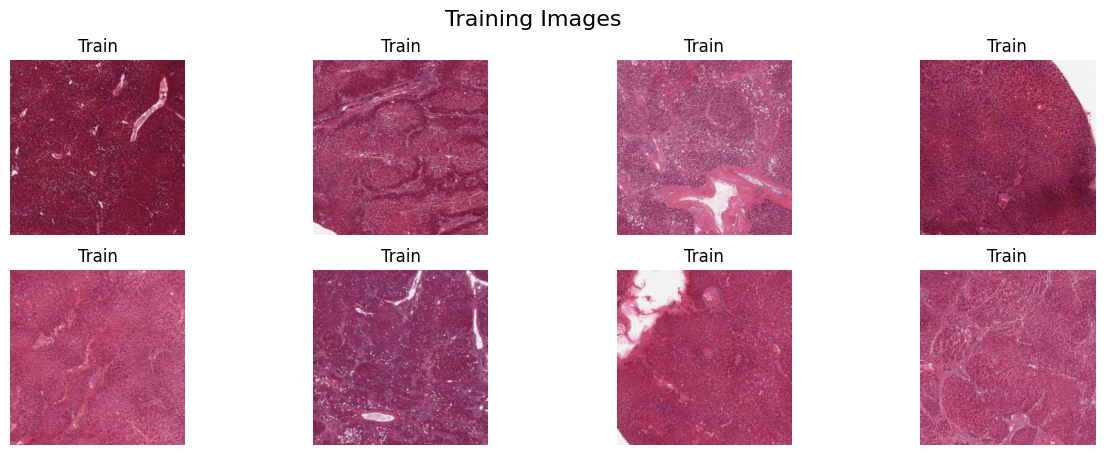

Testing Set Visualization:


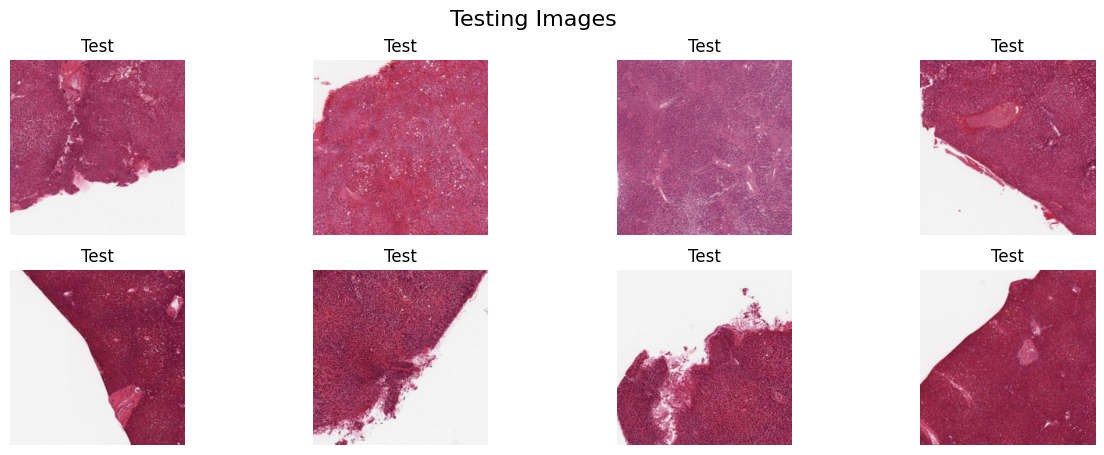

In [8]:
# Load a small subset without transformations for visualization
# Define a simple transform for visualization
viz_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset_viz = datasets.ImageFolder(root=train_dir, transform=viz_transform)
test_dataset_viz = datasets.ImageFolder(root=test_dir, transform=viz_transform)

print("Training Set Visualization:")
show_images(train_dataset_viz, num_images=8, title="Training Images")

print("Testing Set Visualization:")
show_images(test_dataset_viz, num_images=8, title="Testing Images")

In [39]:
# Install necessary libraries
!pip install torch torchvision torchaudio --quiet
!pip install timm --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import timm
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [41]:
# Define the data directory
data_dir = '/content/data'  # Update this path if your data is in a different location

train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')

Classes: ['Train']


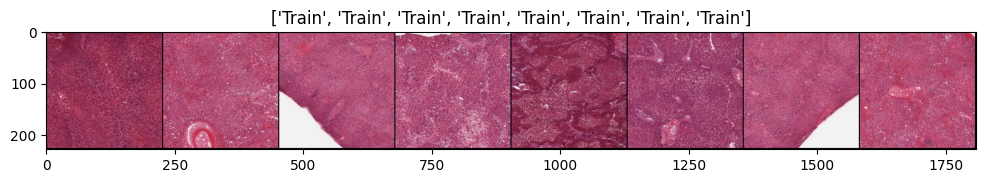

In [42]:
import random
from torchvision.utils import make_grid

# Define image transformations for visualization (no normalization)
viz_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load a small subset for visualization
viz_dataset = datasets.ImageFolder(root=train_dir, transform=viz_transform)
class_names = viz_dataset.classes
print("Classes:", class_names)

# Function to show images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(12, 6))
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes_batch = next(iter(DataLoader(viz_dataset, batch_size=8, shuffle=True)))

# Make a grid from batch
out = make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes_batch])

In [43]:
# Define transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet means
                         std=[0.229, 0.224, 0.225])    # ImageNet stds
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Define data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 160
Number of testing samples: 80


In [44]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the classification head
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2)  # Binary classification

model = model.to(device)

Using device: cuda


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [45]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [46]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    test_losses = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        loop = tqdm(train_loader, desc='Training', leave=False)
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            loop.set_postfix(loss=loss.item())

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(epoch_loss)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Evaluation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            loop = tqdm(test_loader, desc='Evaluating', leave=False)
            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects.double() / len(test_dataset)
        test_losses.append(epoch_loss)

        print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')

    print(f'Best Test Acc: {best_acc:.4f}')
    return train_losses, test_losses

# Train the model
num_epochs = 10
train_losses, test_losses = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/10
----------


Train Loss: 0.0592 Acc: 0.9813


Test Loss: 0.0000 Acc: 1.0000
Epoch 2/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Epoch 3/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Epoch 4/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Epoch 5/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Epoch 6/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Epoch 7/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Epoch 8/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Epoch 9/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Epoch 10/10
----------


Train Loss: 0.0000 Acc: 1.0000


Test Loss: 0.0000 Acc: 1.0000
Best Test Acc: 1.0000


<ipython-input-47-b8a968a259a3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth'))
/usr/local/lib/python3.10/dist-packa

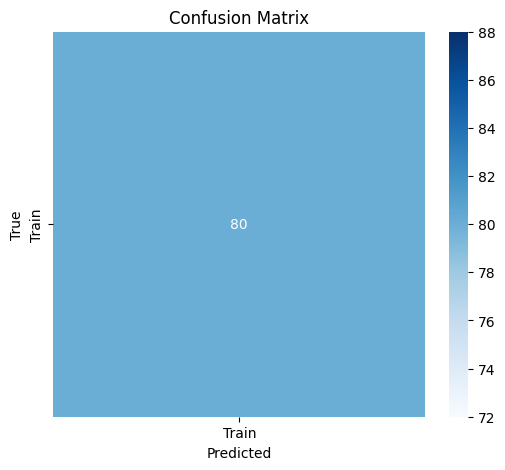

Classification Report:
              precision    recall  f1-score   support

       Train       1.00      1.00      1.00        80

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [47]:
# Load the best model
model.load_state_dict(torch.load('best_vit_model.pth'))

# Function to evaluate the model
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        loop = tqdm(dataloader, desc='Evaluating', leave=False)
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Evaluate the best model
evaluate_model(model, test_loader, class_names)

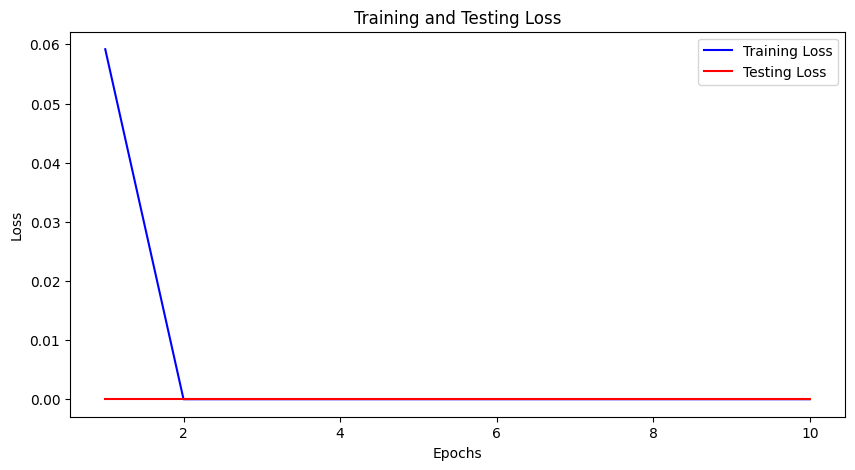

In [48]:
# Plot training and testing loss
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Function to denormalize and convert tensor to numpy array for visualization
def denormalize(tensor):
    """
    Denormalizes an image tensor using ImageNet mean and std.
    Args:
        tensor (Tensor): Normalized image tensor.
    Returns:
        Tensor: Denormalized image tensor.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
    tensor = tensor * std + mean
    return tensor

# Function to display a grid of images with true and predicted labels
def visualize_predictions(model, dataloader, class_names, num_images_per_class=5):
    """
    Visualizes predictions of the model on a few images from each class.

    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): DataLoader for the test set.
        class_names (list): List of class names.
        num_images_per_class (int): Number of images to display per class.
    """
    model.eval()
    images_per_class = {cls: 0 for cls in class_names}
    max_images = num_images_per_class * len(class_names)
    images_displayed = 0

    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_displayed >= max_images:
                    break

                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]

                if images_per_class[true_label] < num_images_per_class:
                    images_per_class[true_label] += 1
                    images_displayed += 1

                    ax = plt.subplot(len(class_names), num_images_per_class, images_displayed)
                    img = denormalize(inputs[i].cpu())
                    img = img.numpy().transpose((1, 2, 0))
                    img = np.clip(img, 0, 1)
                    plt.imshow(img)
                    plt.title(f"True: {true_label}\nPred: {pred_label}")
                    plt.axis('off')

            if images_displayed >= max_images:
                break

    plt.tight_layout()
    plt.show()


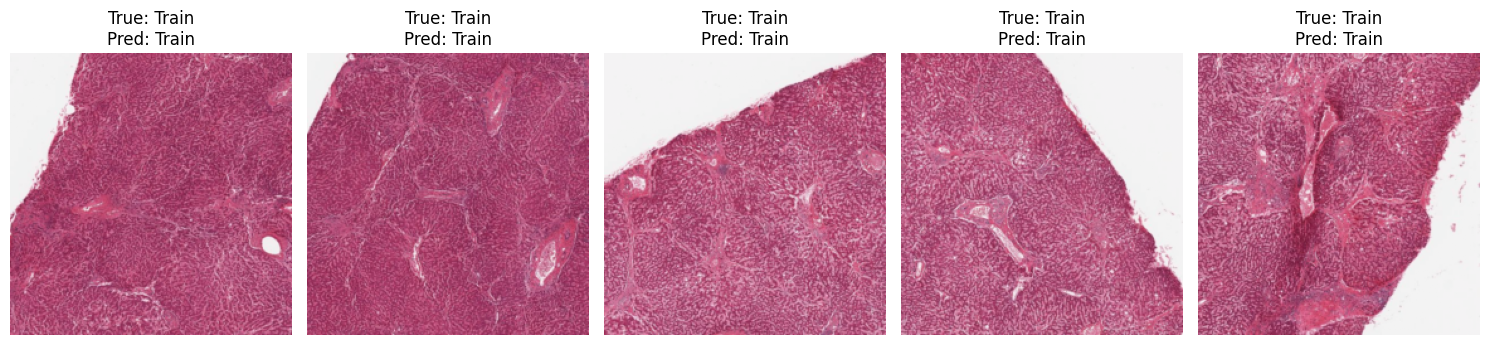

In [51]:
# Number of images to display per class
num_images_per_class = 5

# Visualize predictions
visualize_predictions(model, test_loader, class_names, num_images_per_class=num_images_per_class)

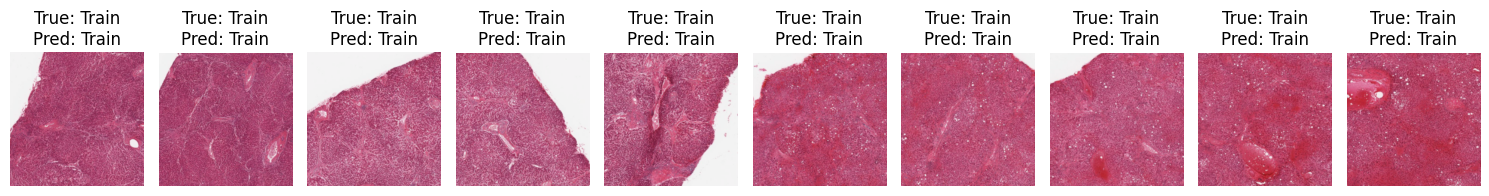

In [52]:
# Number of images to display per class
num_images_per_class = 10

# Visualize predictions
visualize_predictions(model, test_loader, class_names, num_images_per_class=num_images_per_class)